# Mean-Variance Portfolio Theory

Chao Cheng | May 2019

The random rates of return of portfolios can be represented on a two-dimensional graph with standard deviation (volatility) as the horizontal axis, and mean as the vertical axis. This visualization is known as the __Mean-Standard Deviation Diagram__.

When given the option of choosing from a selection of portfolios with the same mean rate of return, but different standard deviations, a rational investor will prefer the portfolio with the lowest standard deviation, corresponding to the left-most point when the portfolios are placed on a Mean-Standard Deviation Diagram.

Similarly, when given a selection of portfolios with the same standard deviation, but differing mean rates of return, a rational investor will prefer the portfolio with the highest mean rate of return, corresponding to the highest point when the portfolios are placed on a Mean-Standard Deviation Diagram.

In short, a rational investor looks to minimize standard deviation while maximizing mean rate of return. The set of portfolios which satisfy these conditions is known as the __Efficient Frontier__, and the portfolio with the lowest standard deviation is known as the __Minimum-Variance Point__. Of the portfolios comprising the Efficient Frontier, the __Sharpe Ratio__ can be used to determine the portfolio with the best risk-adjusted performance.

_This notebook was written by following Bernard Brenyah's [article](https://medium.com/python-data/effient-frontier-in-python-34b0c3043314) on Medium, as well as Thomas Wiecki's [blog post](https://blog.quantopian.com/markowitz-portfolio-optimization-2/) on Quantopian._

## 1. Obtaining Data

In [1]:
%load_ext dotenv
%dotenv
import os
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#  Apple / Amazon / Facebook / Google / Microsoft / Michael Kors / Macy's / Ralph Lauren
stocks = ["AAPL", "AMZN", "FB", "GOOGL", "MSFT", "KORS", "M", "RL"]

quandl.ApiConfig.api_key = os.environ.get("API_TOKEN")
stock_data = quandl.get_table(
    "WIKI/PRICES",
    ticker=stocks,
    qopts={"columns": ["date", "ticker", "adj_close"]},
    date={"gte": "2014-1-1", "lte": "2016-1-1"}
)

daily_closes = stock_data.set_index("date").pivot(columns="ticker", values="adj_close")

In [3]:
daily_closes.head()

ticker,AAPL,AMZN,FB,GOOGL,KORS,M,MSFT,RL
date,,,,,,,,
2014-01-02,73.523423,397.97,54.710,558.283367,82.41,46.788376,33.532800,163.972456
2014-01-03,71.908415,396.44,54.557,554.210796,82.51,46.919829,33.307202,165.674172
2014-01-06,72.300536,393.63,57.200,560.389870,82.04,46.578052,32.603338,163.327300
2014-01-07,71.783135,398.03,57.920,571.193219,78.94,45.727992,32.856007,164.000506
2014-01-08,72.238063,401.92,58.230,572.381888,77.91,45.430032,32.269454,161.120680


In [4]:
daily_returns = daily_closes.pct_change()[1:]
daily_returns.head()

ticker,AAPL,AMZN,FB,GOOGL,KORS,M,MSFT,RL
date,,,,,,,,
2014-01-03,-0.021966,-0.003845,-0.002797,-0.007295,0.001213,0.002810,-0.006728,0.010378
2014-01-06,0.005453,-0.007088,0.048445,0.011149,-0.005696,-0.007284,-0.021132,-0.014166
2014-01-07,-0.007156,0.011178,0.012587,0.019278,-0.037786,-0.018250,0.007750,0.004122
2014-01-08,0.006338,0.009773,0.005352,0.002081,-0.013048,-0.006516,-0.017852,-0.017560
2014-01-09,-0.012772,-0.002264,-0.017345,-0.009630,0.008728,0.076389,-0.006432,0.003250


In [5]:
annual_returns = daily_returns.mean() * 240
variances = daily_returns.var() * 240
covariance_matrix = daily_returns.cov() * 240

## 2. Generating Random Portfolios

In [6]:
portfolio_returns = []
portfolio_standard_deviations = []

for _ in range(10000):
    # Randomize weights
    w = np.random.random(len(stocks))
    weights = w / sum(w)
    
    # Get return of portfolio
    p_return = np.dot(weights, annual_returns)
    portfolio_returns.append(p_return)
    
    # Get standard deviation of portfolio
    p_variance = np.dot(np.dot(weights.T, covariance_matrix), weights)
    p_standard_deviation = np.sqrt(p_variance)
    portfolio_standard_deviations.append(p_standard_deviation)

portfolios = pd.DataFrame({
    "Standard Deviation": portfolio_standard_deviations,
    "Return": portfolio_returns
})

In [7]:
portfolios.head()

,Standard Deviation,Return
0,0.177217,0.065026
1,0.173381,0.005612
2,0.184967,0.132544
3,0.169485,0.064568
4,0.177411,0.064186


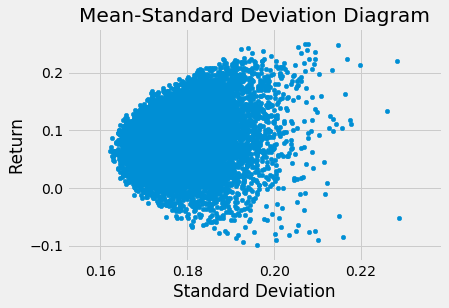

In [8]:
plt.style.use("fivethirtyeight")
portfolios.plot.scatter(
    title="Mean-Standard Deviation Diagram",
    x="Standard Deviation",
    y="Return"
)


## 3. Solving the Markowitz Problem

In [9]:
import cvxopt as opt

# Turn off progress printing 
opt.solvers.options['show_progress'] = False

# Set quadratic variables
n = len(stocks)
N = 100
mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
S = opt.matrix(np.array(covariance_matrix))
pbar = opt.matrix(annual_returns)

# Create constraint matrices
G = -opt.matrix(np.identity(n))
h = opt.matrix(0.0, (n ,1))
A = opt.matrix(1.0, (1, n))
b = opt.matrix(1.0)

# Calculate efficient frontier weights using quadratic programming
optimal_weights = [opt.solvers.qp(mu*S, -pbar, G, h, A, b)["x"] for mu in mus]

# Calculate standard deviations and returns for frontier
optimal_standard_deviations = [np.sqrt(opt.blas.dot(x, S*x)) for x in optimal_weights]
optimal_returns = [opt.blas.dot(pbar, x) for x in optimal_weights]

optimal_portfolios = pd.DataFrame({
    "Standard Deviation": optimal_standard_deviations,
    "Return": optimal_returns
})

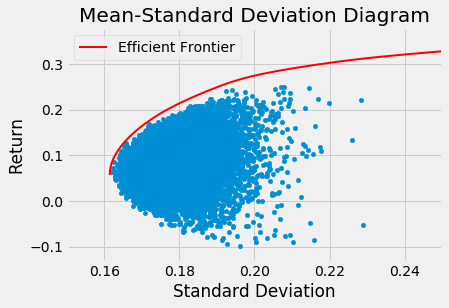

In [10]:
ax = portfolios.plot.scatter(
    title="Mean-Standard Deviation Diagram",
    x="Standard Deviation",
    y="Return"
)
optimal_portfolios.plot.line(
    label="Efficient Frontier",
    x="Standard Deviation",
    y="Return",
    color="red",
    linewidth=2,
    xlim=(0.15, 0.25),
    ax=ax
)

## 4. Minimum Variance and Sharpe Ratio

In [11]:
optimal_portfolios.sort_values(by=["Standard Deviation"], ascending=True).head()

,Standard Deviation,Return
99,0.161474,0.056962
98,0.161474,0.057018
97,0.161474,0.057081
96,0.161474,0.057151
95,0.161474,0.057230


In [12]:
min_variance_index = optimal_portfolios.idxmin()["Standard Deviation"]
min_variance = optimal_portfolios.loc[min_variance_index]

min_variance_portfolio = pd.DataFrame({
    "Standard Deviation": [min_variance["Standard Deviation"]],
    "Return": [min_variance["Return"]]
})

In [13]:
risk_free_rate = 0.023  # US Treasury bond 12-month yield

optimal_portfolios["Sharpe Ratio"] = (optimal_portfolios["Return"] - risk_free_rate) / optimal_portfolios["Standard Deviation"]

In [14]:
optimal_portfolios.sort_values(by=["Sharpe Ratio"], ascending=False).head()

,Standard Deviation,Return,Sharpe Ratio
36,0.210828,0.291135,1.271819
35,0.215696,0.297309,1.271738
37,0.206879,0.285632,1.269496
34,0.221673,0.304237,1.268700
33,0.225239,0.308033,1.265467


In [15]:
max_sharpe_index = optimal_portfolios.idxmax()["Sharpe Ratio"]
max_sharpe = optimal_portfolios.loc[max_sharpe_index]

max_sharpe_portfolio = pd.DataFrame({
    "Standard Deviation": [max_sharpe["Standard Deviation"]],
    "Return": [max_sharpe["Return"]]
})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x116e6e0b8>],
      dtype=object)

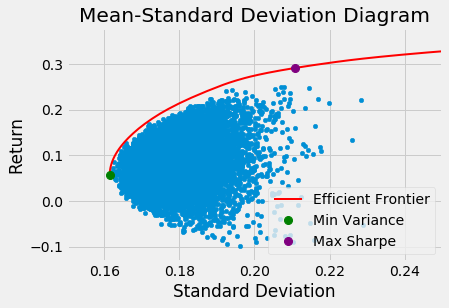

In [16]:
ax = portfolios.plot.scatter(
    title="Mean-Standard Deviation Diagram",
    x="Standard Deviation",
    y="Return"
)
optimal_portfolios.plot.line(
    label="Efficient Frontier",
    x="Standard Deviation",
    y="Return",
    color="red",
    linewidth=2,
    ax=ax
)
min_variance_portfolio.plot(
    label="Min Variance",
    x="Standard Deviation",
    y="Return",
    color="green",
    marker="o",
    markersize=8,
    linestyle="none",
    subplots=True,
    ax=ax
)
max_sharpe_portfolio.plot(
    label="Max Sharpe",
    x="Standard Deviation",
    y="Return",
    color="purple",
    marker="o",
    markersize=8,
    linestyle="none",
    xlim=(0.15, 0.25),
    subplots=True,
    ax=ax
)

## 5. Evaluation

In [17]:
min_variance_weights = np.array(optimal_weights[min_variance_index])
max_sharpe_weights = np.array(optimal_weights[max_sharpe_index])
equal_weights = np.full(len(stocks), 1 / len(stocks))

new_stock_data = quandl.get_table(
    "WIKI/PRICES",
    ticker=stocks,
    qopts={"columns": ["date", "ticker", "adj_close"]},
    date={"gte": "2016-1-1", "lte": "2018-1-1"}
)

new_daily_returns = new_stock_data.set_index("date").pivot(columns="ticker", values="adj_close").pct_change()[1:]

min_variance_portfolio_returns = new_daily_returns.dot(min_variance_weights).squeeze() + 1
max_sharpe_portfolio_returns = new_daily_returns.dot(max_sharpe_weights).squeeze() + 1
equally_weighted_portfolio_returns = new_daily_returns.dot(equal_weights) + 1

initial_investment = 10000
min_variance_portfolio_value = min_variance_portfolio_returns.cumprod() * initial_investment
max_sharpe_portfolio_value = max_sharpe_portfolio_returns.cumprod() * initial_investment
equally_weighted_portfolio_value = equally_weighted_portfolio_returns.cumprod() * initial_investment

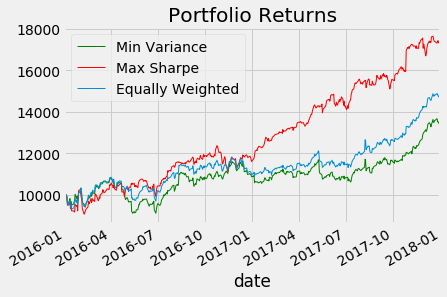

In [18]:
ax = min_variance_portfolio_value.plot.line(
    label="Min Variance",
    title="Portfolio Returns",
    color="green",
    linewidth=1,
    legend=True
)
max_sharpe_portfolio_value.plot.line(
    label="Max Sharpe",
    color="red",
    linewidth=1,
    legend=True,
    ax=ax
)
equally_weighted_portfolio_value.plot.line(
    label="Equally Weighted",
    linewidth=1,
    legend=True,
    xlim=(pd.Timestamp(2016, 1, 1), pd.Timestamp(2018, 1, 1)),
    ax=ax
)